Demography 88<br>
Fall 2017<br>
Carl Mason (cmason@berkeley.edu)<br>
# Lab 8: The Mariel Boatlift: a "*Natural Experiment*"

This week and next, we will explore the labor market effects of the Mariel Boatlift.  David Card (world famous economist who happens to teach at Berkeley) saw the boatlift as a "natural experiment" -- in which the supply of labor in Miami was increased suddenly, unexpectedly and in some important ways: randomly.  In his famous 1990 paper,  "The Impact of the Mariel Boatlift on the Miami Labor Market", Card sets out to measure the impact of this labor market change on wages and employment status of pre-boatlift residents of Miami.

This week and next, we will first replicate and then modestly extend Card's paper.  Of course, this would be an excellent time to have **already** read the paper -- which is available on jstor as well as at: [http://davidcard.berkeley.edu/papers/mariel-impact.pdf]

The key substantive issue is whether and to what extent an increase in the labor supply leads to a reduction in wages of those previously resident.  This is precisely the question that we addressed in our discussion of Clemen's trillion dollar bills and the simple neoclassical model of immigration depicted in this totally viral app: http://shiny.demog.berkeley.edu/carlm/EconImmig0/,

The key technical challenge is to bootstrap a statistic that is  more complicated than a mean -- and the incorporation of sample weights. In many ways this project is structurally very similar to the Wage Impact lab from last week, except that it is a bit more complicated.

What we are going to ultimately do is called a "difference in differences" estimate.  We'll get into details of that next week, but what you need to keep in mind this week is that we're going to compute the *difference* between the mean earnings of a well defined group of workers in Miami and a similar group of workers in a "control" group of similar cities. We're going to do that difference computation at a time *before* the Mariel boatlift and again a few years *after* the boatlift.  The we'll compare the two differences.  If the difference got bigger(or smaller)  we can attribute that change to the Mariel boatlift.  Essentially, we will assume that anything important (but unrelated to the Mariel boatlift) that happened during that interval -- had an equal effect on both Miami and the control cities.  As usual, we are oversimplifying a bit -- but the gist of it is that the "difference in differences" framework, provides a way of "controlling" for all sorts of unobserved things.  

It is probably worth re-reading the above paragraph, because if you get what it's saying,  this lab is going to make a lot more sense.


The steps involved are:
1. Recreate tables 1, 3 and 4 of Card's famous paper.
1. Draw some graphs to illustrate the quantities (differences) in question.
2. Compare our findings with Card's regression based  outcomes.
3. Use bootstrap to quantify our uncertainty about the effects on the labor market disaggregated by education and occupation -- tests which are not part of the original paper.

We will accomplish steps 1&2 this week and 3&4 next week.

The data that we will use is of course the same as that used by Professor Card: the "Monthly Outgoing Rotation Groups" from the Current Population Survey (CPS). The CPS is a venerable survey which has been consistently conducted since unemployment was invented in the 1930s.  The survey is done every month by the Census Bureau for the Bureau of Labor Statistics and its purpose is to measure unemployment.  To do so  it asks a series of questions which come down to: "Do you have a job" and if not "Are you looking for one".  The latter determines whether or not the respondent is "in the labor force" and the former whether or not the person is employed. 

Of course, because surveys of this sort are quite expensive, the CPS does not merely ask the Employed?/Looking? questions but rather administers an impressive battery of questions on a wide range of topics including things closely related to employment such as  education and occupation, but also on topics of broader  interest to academics and policy makers-- such as computer and internet use; health insurance; tobacco use; veteran status; migration and civic engagement. Most of these questions are contained in what are known as monthly "supplements" to the "base survey" (which is concerned with employment).  Best of all, lots these data are available through IPUMS http://ipums.org. The data for this lab, however, were downloaded originally from the NBER site which makes the data available in a form much closer to what Professor Card used back in the Twentieth Century.
http://http://www.nber.org/data/morg.html.

The "outgoing rotation groups" (ORG) refers to the way the survey is conducted: each month a new group of respondents is selected. Each group is then polled for four consecutive months; then left alone for next eight months; and then polled again for four months. The income and employment questions in which we are interested, are asked *only* in the fourth and eighth interviews. This all means that:

1. Each respondent (household) is asked these questions two times during their 16 months of survey participation.
2. Each month only one eighth of currently empaneled CPS respondents are asked these questions.


In [1]:
# Run this cell to import the stuff we'll need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

%matplotlib inline
from datascience import Table
from datascience.predicates import are
from IPython.display import HTML, IFrame, display
datasite="https://courses.demog.berkeley.edu/mason88/data/"
quizsite="https://courses.demog.berkeley.edu/mason88/cgi-bin/quiz.py"
  
def cquiz(qno) : 
    import IPython, requests 
    try:
        sid
    except NameError: 
        print("HEY! did you enter your sid way up at the top of this notebook?")
    Linkit='{0}?qno={1}&sid={2}'.format(quizsite,qno,sid)
    #print(Linkit)
    html = requests.get(Linkit)
    #display(IFrame(Linkit, 1000, 300))
    display(IFrame(Linkit, 1000, 400))


    
######################
# Here it is ... the obvious place to put your student id
sid=""
######################
if sid == "" :
    print("HEY! didn't I tell you to put your sid in the obvious place")
 


HEY! didn't I tell you to put your sid in the obvious place


In [2]:
   
###
# put your student id in the obvious place below - or you will find yourself typing it quite frequently
###
sid=""

if sid == "" :
    print("HEY! didn't I tell you to put your sid in the obvious place")

HEY! didn't I tell you to put your sid in the obvious place


In [4]:
### #### #### ####
###  SELECTING  LAB  PARTNERS
### ### #### ####

#N is will not be included in the output so add one to the highest number asigned
N=4
numbers=np.arange(N)
print(np.mod(N,2))
if (not np.mod(N,2) == 0) :
    numbers=np.append(numbers,"lucky")
    #numbers=np.append(numbers,N)
    N+=1
numbersTab=Table().with_column('n',numbers)
randomized=numbersTab.sample(k=N,with_replacement=False)
selection=randomized['n']
selection.shape = (2,int(N/2))
Table().with_columns('zero',selection[0],'one',selection[1]).show()

0


zero,one
0,3
1,2


In [5]:
## With whom are you working today?
cquiz('mariel-01partners')

In [6]:
# Read the data -- "morg" stands of "merged outgoing rotation groups" which are a subset of the data collected in 
# Current Population Survey

morg=Table.read_table(datasite+"morgClean.csv")

# and add the variable lnWage for log of hourly wage
morg=morg.with_column('lnWage',np.log(morg['Earnhr']))
# and a yes/no for Miami
morg.append_column('Miami',[m['SMSA'] == 'Miami' for m in morg.to_array()])
print(np.min(morg['age']))
print(np.max(morg['age']))
morg

16
61


year,age,sex,EthRace,Educ,SMSA,class,Earnhr,Labf,Occupation,Unemp,occ70,occ80,esr,SelfEmployed,centcity,marital,classer,PrivateSector,hourslwa,Earnwt,Weight3,lnWage,Miami
1979,56,2,NonHisp:white,13,LA-LongBeach,1,nan,True,Clerical,0,372,nan,1,False,2,4,1,1,40,581.165,565.41,nan,False
1979,54,1,NonHisp:white,12,LA-LongBeach,3,nan,True,More Skilled Service Wrks,0,962,nan,1,False,2,4,2,0,40,585.795,592.78,nan,False
1979,23,1,NonHisp:white,13,LA-LongBeach,1,11.3776,True,Transportation Operatives,0,705,nan,1,False,2,1,1,1,16,584.448,563.823,2.43164,False
1979,21,2,NonHisp:white,12,LA-LongBeach,1,4.0017,True,Clerical,0,301,nan,1,False,2,1,1,1,40,600.214,585.407,1.38672,False
1979,26,1,NonHisp:white,12,LA-LongBeach,1,12.0619,True,Clerical,0,305,nan,1,False,2,3,1,1,40,615.096,590.453,2.49005,False
1979,27,1,NonHisp:white,12,LA-LongBeach,1,nan,False,Craftsmen,nan,530,nan,4,False,2,3,1,1,nan,621.214,590.453,nan,False
1979,51,2,NonHisp:white,14,LA-LongBeach,6,nan,True,Managers,0,245,nan,1,True,2,1,3,0,40,557.721,585.217,nan,False
1979,54,1,NonHisp:white,12,LA-LongBeach,6,nan,True,Managers,0,245,nan,1,True,2,1,3,0,55,562.312,572.053,nan,False
1979,25,1,NonHisp:white,14,LA-LongBeach,6,nan,True,Managers,0,245,nan,1,True,2,7,3,0,40,635.56,619.837,nan,False
1979,17,2,NonHisp:white,11,LA-LongBeach,1,nan,False,Operatives,nan,643,nan,5,False,2,7,1,1,nan,594.488,577.88,nan,False


## Recreating Table 1

Table 1 in Card's paper,  gives some descriptive statistics for Miami in 1979 before the Mariel Boatlift happens.

Recreating it will give us a feel for both the structure of the data and the situation in Miami in 1979.

Because the CPS is responsible for producing an unemployment statistic for each and every state, county and SMSA-- by race, ethnicity and other demographic characteristics, a *simple random sample* turns out **not** to be the best way to do it.  Collecting these data are expensive, and in order to be assured of having enough observations in **each** geographical/demographic category, a simple random sample would have to be very large (expensive).  The way this is avoided is with a "stratified" random sample, which is a type of "probability sample" (as described: https://www.inferentialthinking.com/chapters/08/5/sampling.html) .  To oversimplify a bit,  a stratified random sample contains a certain number of observations chosen at random from *each*  geographical area of interest. Then weights are calculated to adjust statistics that are computed from those data.  In order to calculate theses weights it is necessary to know each observation's probability of selection.  In the simplest case, this is just a the number of observations collected from the area divided by the number of individuals in the area who could have been selected. In the case of the CPS, the sample is stratified in many more ways besides geography, so even within a region and year the weights vary across individuals. 

The way to use weights, in the present (typical) case, is to think of them as the number of people in the universe who are *represented* by each individual in the sample.  Thus the number of people in area A =$\sum_{i\in{A}}{w_i}$ where $w_i$ is the sample weight of individual i and $i\in{A}$ indicates that individual i lives in area A.

Similarly, the weighted average of some characteristic, c, of people who live in area A would be given by: 
$$\frac{\sum_{i\in{A}}{(c_i*w_i)}}{\sum_{i\in{A}}{w_i}}$$

The above formulae are what David Card used to compute the figures in his Table 1.  It should also look pretty familiar--it is the same formula that we used in the Wage Impact lab.

In [7]:
# Computing Table 1-A
m79=morg.where('SMSA','Miami').where('year',1979)
tab1a=[]
for er in np.unique(m79['EthRace']) :
    temp=m79.where('EthRace',er)
    tab1a.append(
        {'EthRace' : er,
            'N': np.sum(temp['Earnwt']),
        'meanEd' : np.average(temp['Educ'],weights=temp['Earnwt']),
        'meanLPF' : np.average(temp['Labf'],weights=temp['Earnwt'])
        }
    )
    
Table().from_records(tab1a)

EthRace,N,meanEd,meanLPF
Cuban,252373,10.9636,0.771672
HispanNotCuban,94051.8,11.5964,0.6822
NonHisp:black,244060,11.3968,0.682698
NonHisp:other,9829.81,9.74478,0.486744
NonHisp:white,319268,12.8265,0.755779


In [8]:
cquiz('marl0-01')

In [9]:
# Computing Table 1-B
m79=morg.where('SMSA','Miami').where('year',1979)

tab1b=[]
for er in np.unique(m79['EthRace']) :
    temp=m79.where('EthRace',er).where('Labf',True)
    tab1b.append(
        {'EthRace' : er,
            'N': np.sum(temp['Earnwt']),
        'meanEd' : np.average(temp['Educ'],weights=temp['Earnwt']),
        'meanLPF' : np.average(temp['Labf'],weights=temp['Earnwt'])
        }
    )
    
Table().from_records(tab1b)

EthRace,N,meanEd,meanLPF
Cuban,194749,11.304,1
HispanNotCuban,64162.2,11.8998,1
NonHisp:black,166619,11.756,1
NonHisp:other,4784.6,10.7337,1
NonHisp:white,241296,13.11,1


In [10]:
cquiz('marl0-02')

In [11]:
# Computing Table 1-C
# The third panel of Table 1 has a different structure from ther first two
m79=morg.where('SMSA','Miami').where('year',1979)

tab1c=[]
for er in np.unique(m79['EthRace']) :
    temp=m79.where('EthRace',er).where('Occupation',are.not_contained_in('nan'))
    #temp.append_column('keep',[~np.isnan(oc) for oc in temp['Occupation']])
    for occ in np.unique(m79['Occupation']) :
        
        prop=np.average((temp['Occupation'] == occ),weights=temp['Earnwt'])
       
        tab1c.append({
            'Occupation': occ,
            'EthRace':er,
            'prop' :prop
        })
 
     
    
    
Table().from_records(tab1c).pivot('EthRace','Occupation',values='prop', collect=np.sum).show()


Occupation,Cuban,HispanNotCuban,NonHisp:black,NonHisp:other,NonHisp:white
Clerical,0.200512,0.215441,0.218714,0.508394,0.249027
Craftsmen,0.141896,0.0965855,0.0766321,0,0.130476
Farm Workers,0.00293736,0.00633948,0.00697196,0,0.00406815
Laborers,0.0430156,0.0410237,0.114214,0,0.0432728
Less Skilled Service Wrks,0.0497818,0.0978961,0.132449,0.15781,0.0537394
Managers,0.0714213,0.0895843,0.0242351,0.0258511,0.133467
More Skilled Service Wrks,0.046565,0.0487324,0.143239,0.075978,0.0459895
Operatives,0.221724,0.165666,0.0798075,0,0.0540413
Professional/Technical,0.0945654,0.1121,0.109809,0,0.186416
Sales,0.0731248,0.0850554,0.0353598,0.231967,0.0687129


## Are these numbers close enough ?

It would be nice if we could precisely reproduce Card's numbers -- since we are using the same data set, but life is not that simple.

Let's discuss what might be wrong here and whether we can bear to go on.

## Table 3  -- comparing log wages

### Why log wages ?

There are a couple of reasons that economists generally prefer to use $ln(wage)$ rather than plain old wage in their analyses. 

- Wages cannot be negative.  That's a good thing for workers, but for labor economists who want to build wage prediction models, it's kind of a drag.  Using $ln(wage)$ means that when finished, one can exponentiate and be sure that the result will not be negative.

- Wages tend to be "right skewed" which is jargon for: there tend to be more folks with super high wages than one would expect *if the distribution were gaussian normal* 

- Wages are money and money, as we learned in the first two weeks of this class, is (in one way) like living things -- it's growth rate is determined by it's current level (as if it reproduced).  In other words, it makes sense to model wage growth as an exponential.

## How much do these things matter in our current context ?

In [12]:
# Computing Table 3
# create variable T/F Miama v control
morg.append_column('Miami',[m['SMSA'] == 'Miami' for m in morg.to_array()])
#add the variable lnWage for log of hourly wage
morg=morg.with_column('lnWage',np.log(morg['Earnhr']))
res=[]
for miami in [True,False] :
    for er in np.unique(morg['EthRace']) :
        for yr in np.unique(morg['year']) :
            print("miami:{0} {1} {2}".format(miami,er,yr),end='    \r')
            temp=morg.where('Miami',miami).where('EthRace',er).where('year',yr).where('Earnhr',are.above(0))
            lnw=np.average(temp['lnWage'],weights=temp['Earnwt'])
            res.append({
                'Miami': miami,
                'EthRace' : er,
                'year' : yr,
                'lnwage': lnw
            })    
t3=Table().from_records(res)   
t3

EthRace,Miami,lnwage,year
Cuban,True,1.57298,1979
Cuban,True,1.52982,1980
Cuban,True,1.50606,1981
Cuban,True,1.49306,1982
Cuban,True,1.48313,1983
Cuban,True,1.52699,1984
Cuban,True,1.48209,1985
HispanNotCuban,True,1.51451,1979
HispanNotCuban,True,1.53782,1980
HispanNotCuban,True,1.52682,1981


### We can use .pivot() to display the table more conveniently

In [13]:

print('Miami')
t3.where('Miami',True).pivot('year','EthRace',values='lnwage',collect=np.mean).show()
print("Control")
t3.where('Miami',False).pivot('year','EthRace',values='lnwage',collect=np.mean)

Miami


EthRace,1979,1980,1981,1982,1983,1984,1985
Cuban,1.57298,1.52982,1.50606,1.49306,1.48313,1.52699,1.48209
HispanNotCuban,1.51451,1.53782,1.52682,1.49057,1.46891,1.58864,1.52775
NonHisp:black,1.58852,1.54089,1.60878,1.48397,1.47248,1.5755,1.6014
NonHisp:other,1.48762,1.52997,1.57803,1.60272,1.47352,1.74762,1.81052
NonHisp:white,1.85121,1.81886,1.83403,1.81343,1.77927,1.80212,1.77751


Control


EthRace,1979,1980,1981,1982,1983,1984,1985
Cuban,1.80247,1.69987,1.56995,1.67922,1.52883,1.6077,1.82178
HispanNotCuban,1.63745,1.61223,1.5856,1.58168,1.55946,1.57322,1.54308
NonHisp:black,1.73836,1.70007,1.71748,1.71314,1.69156,1.66348,1.6466
NonHisp:other,1.86499,1.75937,1.83436,1.82333,1.80953,1.80809,1.76857
NonHisp:white,1.91287,1.88481,1.87831,1.87498,1.85788,1.86072,1.86288


### Does our Table 3 match Card's Table 3?

In the next cell we'll read (some of) Card's Table 3 numbers -- which your instructor took the trouble of typing into a file (your welcome)  and we'll compare his values with those that we just computed.

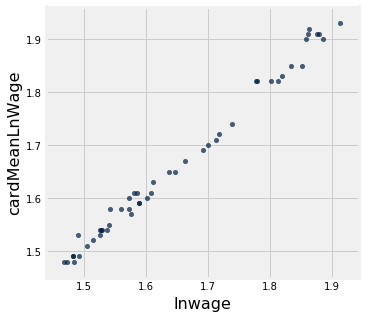

In [14]:
## read data from Card's Table 3 which your instructor has thoughtfully typed for you
cardT3=Table.read_table('https://courses.demog.berkeley.edu/mason88/data/cardTable3.csv')
cardT3.append_column('Miami',cardT3['Miami'] =='yes')
cardT3.relabel('meanLnWage','cardMeanLnWage')
#cardT3.show(5)
cardT3.append_column('lab',[":".join([str(x[0]),str(x[1]),str(x[2])]) for x in cardT3.to_array()])
t3.append_column('lab',[":".join([str(x[0]),str(x[3]),str(x[1])]) for x in t3.to_array()])
t3match=cardT3.join('lab',t3)

t3match.select('cardMeanLnWage','lnwage').scatter('lnwage')

## In therory...

there should be no difference between the numbers that you have computed and those that David Card reported.  And yet,  there *are* small differences.  Given that we are using the same data set and that your instructor had access to Card's computer program,  this is kind of sad. It could certainly be that your instructor has lead you astray (that's happened before) but, of course *I* don't think that's the case. 

What has happened is that time has passed and even though that "monthly outgoing rotation groups" data from 1979-85 *should* not have changed since Card published his famous paper, it appears that that may not be the case.  It appears that small changes to the data are made by both the BLS and NBER (who agregates the data).  The changes are not enough to affect results, but it does emphasize how difficult it is to reproduce results -- even using the same data!

## Diff-in-diff and bootstrap

It should come as no surprise at this point, that our next step is to compute the difference in differences statistic and bootstrap it -- essentially this is the same exercise that we did last week... 

1. Write a function that computes the diff-in-diff statistic
1. Write a loop that (re)samples from the data and calls the diff-in-diff function and stores the results
1. Plot and interpret the results

In [15]:
# A diff-in-diff function

def diffdiff(morg=morg,endyr=1983) :
    """
    expects a table like morg with ln(wages) of individuals in Miami and Control towns;
    returns the diff-in-diff of the ln(wages)
    """
    # log wages will be nan if not in Labor Forc
    morg=morg.where('Labf',True).where('Earnhr',are.above(0))
    res=dict()
    for miami in [True,False] :
        for yr in [1979,endyr] :
            res[(yr,miami)] = np.average(morg.where('year',yr).where('Miami',miami)['lnWage'],
                weights=morg.where('year',yr).where('Miami',miami)['Earnwt'])
    result=(res[endyr,True]-res[1979,True]) - (res[endyr,False]-res[1979,False])
    return(result)

In [16]:
# bootstrap loop
res=[]
submorg=morg.where('Labf',True).where('Earnhr',are.above_or_equal_to(0))
endyr=1981
for i in np.arange(100):
    print("trial: {0}  ".format(i),end="\r")
    # To make sure that this works -- we'll take 4 samples one for each term in the diff-in-diff 
    # statistic. the function diffdiff will blow guts if there were no observations for one of the
    # two years in either Miami or the control towns.
    miami79=submorg.where('Miami',True).where('year',1979).sample().to_df()
    
    miami83=submorg.where('Miami',True).where('year',endyr).sample().to_df()

    control79=submorg.where('Miami',False).where('year',1979).sample().to_df()

    control83=submorg.where('Miami',False).where('year',endyr).sample().to_df()

    bsmpl=pd.concat([miami79,miami83,control79,control83])
    res.append(diffdiff(Table().from_df(bsmpl),endyr=endyr))

In [17]:
## Some slightly refined figures for bootstrap results
def bsfigs(res):
    """
    Expects an array of bootstrap results; produces two lovely plots
    """
    plt.figure()
    plt.hist(res)
    plt.title("Histogram of 95 % confidence ")
    p05=Table().with_column('dind',res).percentile(2.5)['dind'][0]
    p95=Table().with_column('dind',res).percentile(97.5)['dind'][0]
    plt.axvline(x=p05,color='red',linewidth=1)
    plt.axvline(x=p95,color='red',linewidth=1)

    plt.figure()
    res.sort()
    plt.plot(res,np.arange(len(res))/len(res),linestyle='-',linewidth=2,color='black')
    plt.title("CDF of dif in difs")
    dtab=Table().with_column('dind',res)
    plt.axvline(dtab.percentile(2.5)[0],linestyle=':',linewidth=2,color='blue')
    plt.axhline(.025,linestyle=':',linewidth=2,color='blue')
    plt.axvline(dtab.percentile(97.5)[0],linestyle=':',linewidth=2,color='gold')
    plt.axhline(.975,linestyle=':',linewidth=2,color='gold')


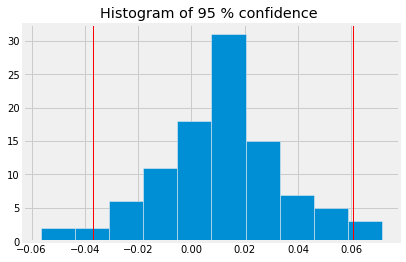

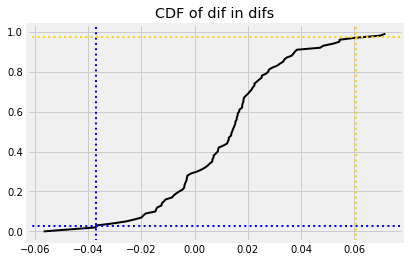

In [18]:
# now call the function that makes pretty graphgs
bsfigs(res)


## Is that all there is to this ?

Of course not.

The analysis above asks the question:  **Can we find an effect on wages in the entire Miami labor market resulting from the Marile Boatlift?** And given the results of the bootstrap, it looks like a pretty good answer is "probably not".

Let's discuss "probably"  and "not" in class 


#### Is this the right question ?

- Should we expect to see an effect on the entire labor market ?
- Are there subgroups in the Miami labor market whom we might expect to *benefit* from an increase in the supply of unskilled labor?
    - Are there perhaps, despite the awesome simplification of Clemens's model, maybe *more than one kind of labor*?  Might some types of labor be *complements* while others *substitutes* ?
    



# In the final segment of this lab,  *you* find two Miami labor market groups that  were affected by the Mariel Boatlift.



You are now an expert in the Miami labor market circa 1980 and in construction of bootstrap estimates of confidence bounds around difference in differences statistics.  Congratulations.   Now it's time to put your skills to work.

Science is not generally an Easter egg hunt -- but this lab is -- we'll discuss the implications of this next week.  But for now concentrate only on winning.  Your job is to generate and test at least 5 hypotheses of *each* sort enumerated below. The goal is to find one group of workers that was hurt by the Mariel Boatlift and one that was helped.  Full credit if you try five definitions of each type of group without finding a significant effect. in other words; Five documented failures is as good as one success.  Save your code so you can present results in class. AND record your hypotheses and results in this google doc.  Hyptheses are first come first served so get there first. https://docs.google.com/a/berkeley.edu/spreadsheets/d/1L905sFMexxC-iMU24-RjyFzhFaF9lR47dgsDDJambyI/edit?usp=sharing


The two types of hypothesis:

1. Group X was negatively affected by the MBL 
1. Group Y was posetively affected by the MBL

Hypotheses of type 1 come down to the claim that Marielito labor is a substitute for this groups' labor and thus greater supply leads to lower price.

Hypotheses of type 2 are claims that group Y benefits from an increase in labor supplied by Marielitos because the two groups' labor is complementary. In other words, additional low skilled labor creates opportunities for members of Group Y.  This is not an effect that is possible in the Clemens/neoclassical models that we looked at last week.


Then write the code necessary to bootstrap it at least 100 times for each group.

The variables that you have by which to define groups are:
1. Age
2. EthRace -- but note that there are too few Cubans in the other cities to make this work.
3. Education
4. Sex
5. Occupation

NOTES:
1. With smaller groups the bootstrap will run MUCH faster. So make sure you run at least 100 trials.
1. The dependent variable, presently Earnhr, is a good choice, but so night be the unemployment rate
1. There are not enough Cubans in the control cities to get an estimate so your group cannot be made up exclusively of Cubans.
1. 1979 has to be the start year,  but what you choose for your end point is up to you.
1. the np.unique() function can be used to find the unique values of a variable -- useful for defining groups.

## Next week in class, you will present your results to the class.
#### No worries presentations will be brief and stress free... as long as you have completed the exercise.



Hypotheses are first come first served so get to the google doc first to stake your scientific claim.  


https://docs.google.com/a/berkeley.edu/spreadsheets/d/1L905sFMexxC-iMU24-RjyFzhFaF9lR47dgsDDJambyI/edit?usp=sharing

Don't worry *too* much about the presentation -- just be prepared to answer four questions:

1. What is your subgroup of interest ?
1. What is the value of your statistic (on the original sample) ?
1. What is the 95 percent confidence interval of your statistic ?
1. What would David Card say about your result?


In [19]:
np.unique(morg['EthRace'])

array(['Cuban', 'HispanNotCuban', 'NonHisp:black', 'NonHisp:other',
       'NonHisp:white'], dtype='<U14')

In [20]:
np.unique(morg['Educ'])
#https://usa.ipums.org/usa-action/variables/EDUC#codes_section

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [21]:
np.unique(morg['Occupation'])

array(['Clerical', 'Craftsmen', 'Farm Workers', 'Laborers',
       'Less Skilled Service Wrks', 'Managers',
       'More Skilled Service Wrks', 'Operatives',
       'Professional/Technical', 'Sales', 'Transportation Operatives',
       'nan'], dtype='<U25')

In [ ]:
# A cell for your work

In [23]:
# Remember to plot your results
#bsfigs(res)

In [24]:
cquiz('marl0-03')

In [25]:
cquiz('marl0-04')

# Congratulations you have completed this week's lab.

### But remember that on Monday,  you will give a short, relaxing presentation on your findings.

In [26]:
cquiz('marl0-eval')